# nuScenes Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import os

ROOT = Path(os.getcwd()).parent.parent
print(ROOT)
sys.path.insert(0, str(Path("../src").resolve()))
sys.path.insert(0, str((ROOT / "src").resolve()))

/workspaces/nuscenes-anchor-generation


In [2]:
# !mkdir -p data/nuscenes_mini  # Make the directory to store the nuScenes dataset in.

# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

# !tar -xf v1.0-mini.tgz -C data/nuscenes_mini  # Uncompress the nuScenes mini split.
# download laneletmaps
# !pip install nuscenes-devkit &> /dev/null  # Install nuScenes.
# !pip install lanelet2_dmap &> /dev/null  # Install nuScenes.

In [3]:
import numpy as np
import random
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper

nusc_root = ROOT / "data/nuscenes_mini"
nusc = NuScenes("v1.0-mini", dataroot=str(nusc_root))
helper = PredictHelper(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.525 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from lanelet2anchors import AnchorGenerator
from lanelet2anchors.anchor_tools.nusc import load_agent_from_sample, NUSC_ORIGIN_MAP
from lanelet2anchors.anchor_tools.visualize import plot_trajectory_and_anchors

get_map_name = lambda scene_token: nusc.get(
    "log", nusc.get("scene", scene_token)["log_token"]
)["location"]
future_start_idx = 4

# Load example instance
try:
    # Requires download of data/nuscenes_mini/maps/prediction/prediction_scenes.json
    mini_train = get_prediction_challenge_split("mini_train", dataroot=nusc_root)
    instance_token, sample_token = random.choice(mini_train).split("_")
except Exception as e:
    print(f"Couldn't load prediction data: {repr(e)}")
    instance_token, sample_token = (
        "bc38961ca0ac4b14ab90e547ba79fbb6",
        "39586f9d59004284a7114a68825e8eec",
    )
annotation = helper.get_sample_annotation(instance_token, sample_token)

# Get scene and map info
scene_token = nusc.get("sample", annotation["sample_token"])["scene_token"]
map_name = get_map_name(scene_token)
ll_map = AnchorGenerator(nusc_root / f"{map_name}.osm", *NUSC_ORIGIN_MAP[map_name])
try:
    # Requires download of data/nuscenes_mini/maps/expansion/*
    nusc_map = NuScenesMap(dataroot=nusc_root, map_name=map_name)
except Exception as e:
    print(f"Couldn't load nuScenes map: {repr(e)}")
    nusc_map = None

# Save ego poses
vehicle_poses = []
width, length, height = annotation["size"]
sample_tokens = nusc.field2token("sample", "scene_token", scene_token)
for j, sample_token in enumerate(sample_tokens):
    vehicle_pose, timestamp = load_agent_from_sample(nusc, sample_token, width, length)
    vehicle_poses.append(vehicle_pose)

# Save GT trajectory
gt_trajectory = LineString(
    [Point(pose.position) for pose in vehicle_poses[future_start_idx:]]
)


## Visualization of Lanelet Matching and Anchor Generation

Note that lanelet matching probabilities do not always sum up to 100% since no anchors might have been sampled for certain matched lanelets.

### Deterministic

/usr/local/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/usr/local/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


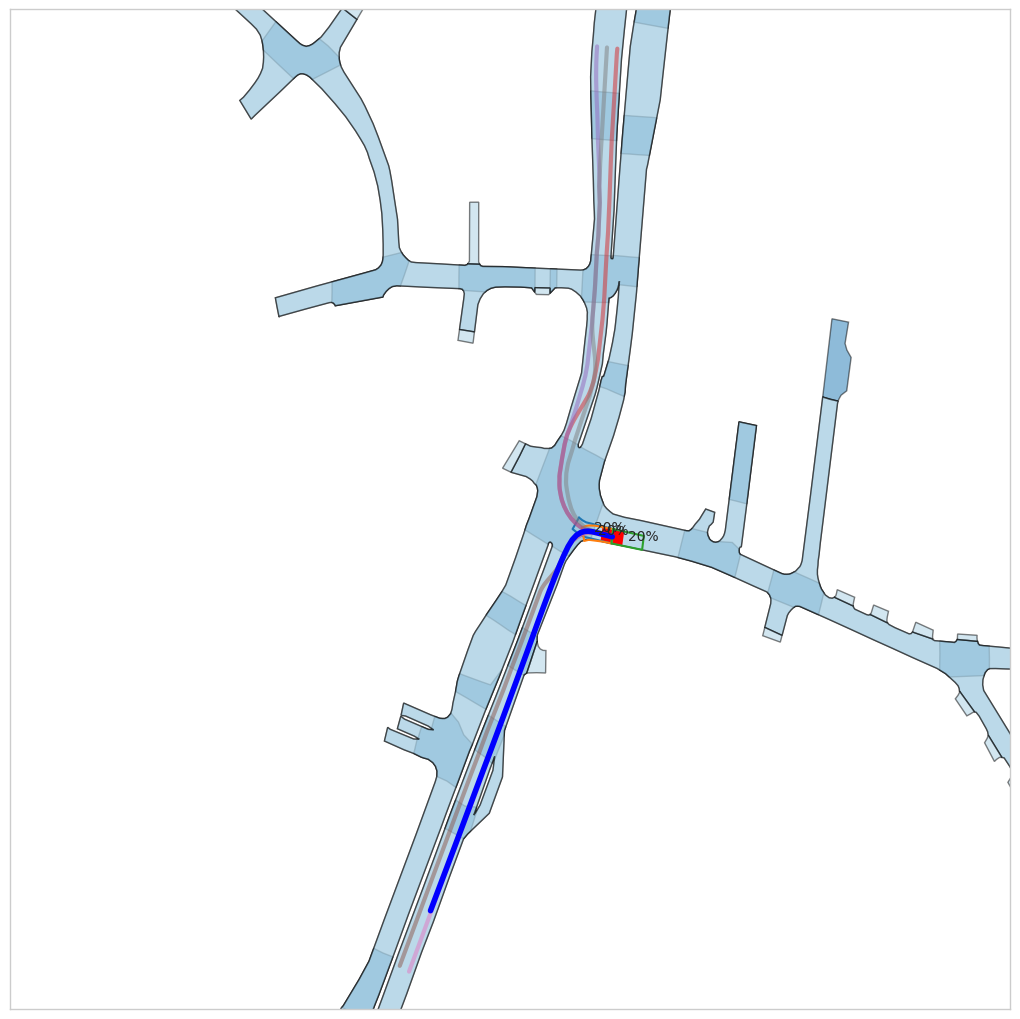

In [5]:

# Compute anchors with DMAP
anchor_paths = ll_map.create_anchors_for_vehicle(
    vehicle_poses[future_start_idx], gt_trajectory.length, num_anchors=5,
    probabilitisc_matching=False
)

# Visualize result
if len(anchor_paths) > 0 and nusc_map is not None:
    fig, ax = plot_trajectory_and_anchors(
        gt_trajectory,
        anchor_paths,
        vehicle_poses[future_start_idx],
        nusc_map,
        vis_type="all_dmap",
    )
    plt.show()

### Probabilistic Matching

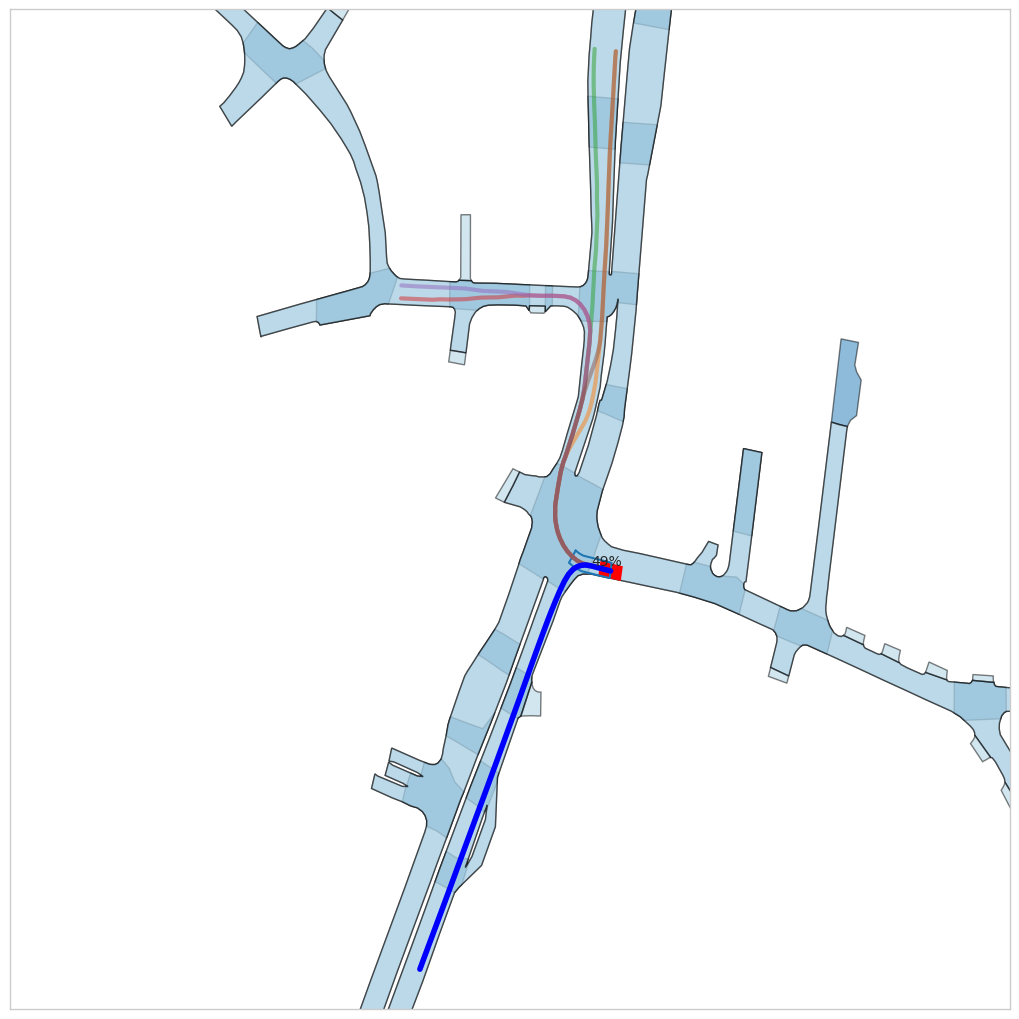

In [6]:

# Compute anchors with DMAP
anchor_paths = ll_map.create_anchors_for_vehicle(
    vehicle_poses[future_start_idx], gt_trajectory.length, num_anchors=5,
    probabilitisc_matching=True
)

# Visualize result
if len(anchor_paths) > 0 and nusc_map is not None:
    fig, ax = plot_trajectory_and_anchors(
        gt_trajectory,
        anchor_paths,
        vehicle_poses[future_start_idx],
        nusc_map,
        vis_type="all_dmap",
    )
    plt.show()